# 1.import data 
There are multiple ways for our program to help you import the flux series you want to fit
- search kepler/tess id;
- self input time series data

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm

from StellarVar.vargppred import VarGPPred
from StellarVar.utils import KOI_CATA
from StellarVar.fig import *
from StellarVar.stellarlightcurve import StellarLightCurve

/media/yangyangli/OS/yangyangli_private/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


You can choose to input xoi(koi/toi) number or xic(kic/tic) number into the StellarLightCurve to search availble
records in Kepler or TESS data archive, In this exmaple, you can specify both kic and koi id but I just give koi 
id here; The lctype have three catalogues: "rotation", "granualtion", "hybrid"(granualtion+rotation), which corresponds to different choose of Gaussian Process(GP) kernel. Since our code is built on one of case study of  [exoplanet](https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/), the details of GP kernel can be find in it. Basically, 
- rotation: one rotation term (two stochasitic harmonica oscillators (SHO) combined, with periods constrained) towards low frequence components

- granulation: one SHO term towards high frequence component

- hybrid: one rotation term + one SHO term

In [2]:
koi = StellarLightCurve(mission="Kepler", xoi_id=752, lctype="hybrid")

<IPython.core.display.Javascript object>


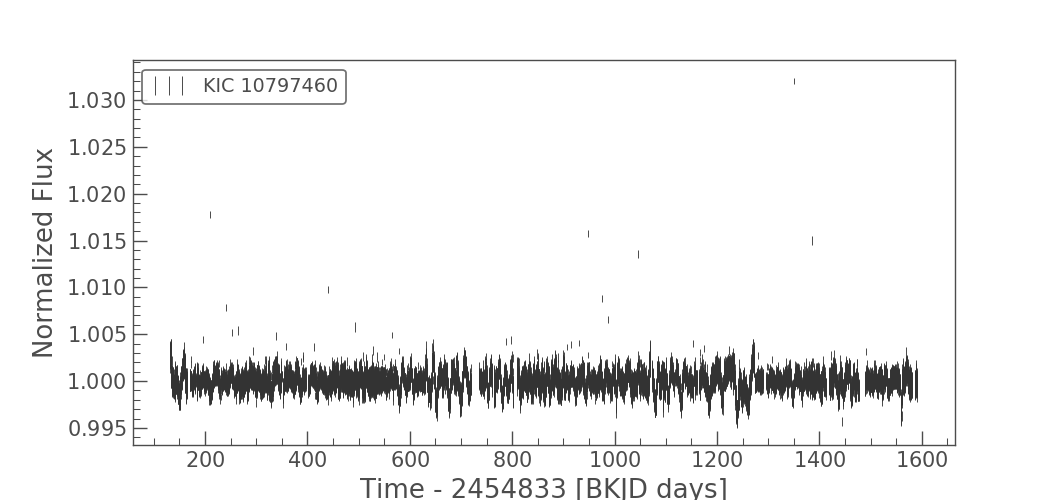

In [3]:
# Take a look at origin light curve(just normalize to 1)
import matplotlib.pylab as plt
%matplotlib notebook
koi.errorbar()

# 2. Prepare the data for GP fitting
In this procedure, we bin the data using mean filter, remove nan values and mask those time stamp with known planet transition. In order not to make heavy burden for the GP fitting, I choose to cut the total light curve into pieces with 1 year duration.

In [4]:
# Reduction for orignal time series
final_lc = koi.bin(binsize=13).removed_nans().masked()
#Measure pieces lightcurves with 1 year length and save it in a hdf5 file.
t0 = final_lc.lcf.time[0]
te = final_lc.lcf.time[-1]
epochs = np.ceil((te - t0) / 365.25)
hdf = pd.HDFStore("./KOI"+str(752)+".h5")

/media/yangyangli/OS/yangyangli_private/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


# 3. Run GP for one epoch (one year data)
You have to notice two parameters here to divide low frequency components from high components and get converged lower bound for initial guess value of periods correctly. They are **window_width** in  **VarGPPred** class and **min_period** property in the instance of **VarGPPred** class. The setting for these two values should depends on the temporal resolution and the bin size you choose.

For example, since the temporal resolution of Kepler long-cadence light curves is around 30 mins and we choose bin size as 13. Then the temporal resolution after binning is around 0.271 days; If we take window width with 11 to separate two components frequency data, the cut-off time should be 2.98 days.

As for **min_period**, it is always set to be larger than the temporal resultion of your targeted light curve.

In [5]:
sub = final_lc.sub_lc(t0, t0 + 365.25)
sub = sub.normalize()
        
#skip empty epochs:
if len(sub.lcf.time) <= 100 :
    print("This epoch does not have enough data points")
    exit
#Gaussian process predict
vgp = VarGPPred(sub, window_width=11)
vgp.min_period = 2 * np.median(np.diff(final_lc.lcf.time))
try:
    trace = vgp.predict()
    summary = pm.summary(trace, varnames=['granulation_logs22', 'granulation_logQ',#'granulation_logz', #'granulation_sigma', 
                                              'granulation_logSw4', 'granulation_logw0', 'granulation_mean2', 'rotation__mix', 
                                              'rotation__logdeltaQ', 'rotation__logQ0', 'rotation__logperiod', 
                                              'rotation__logamp', 'rotation__logs21', 'rotation__mean1'])
except RuntimeError:
    print("Can't fit the model towards your data")
    exit

optimizing logp for variables: [rotation__logQ0, rotation__logperiod]
15it [00:01,  9.93it/s, logp=-1.570659e+04] 
message: Optimization terminated successfully.
logp: -16928.395882689914 -> -15706.58818719225
optimizing logp for variables: [granulation_logQ, granulation_logw0]
18it [00:00, 26.33it/s, logp=-1.641734e+04] 
message: Optimization terminated successfully.
logp: -16928.395882689914 -> -16417.342028975112
optimizing logp for variables: [granulation_logQ, granulation_logs22, granulation_logSw4, granulation_logw0, granulation_mean2, rotation__mix, rotation__logdeltaQ, rotation__logQ0, rotation__logperiod, rotation__logamp, rotation__logs21, rotation__mean1]
62it [00:00, 75.54it/s, logp=-1.485428e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -16928.395882689914 -> -14854.280025138258
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [granulation_logQ, granulation_logs22, granulation_logSw4, granulation_logw0, granulation_mean2, rotation__mix,

In [6]:
#Here is the mcmc fitting summary (Use r_hat and effective sample size to help you 
#judge the converged fitting hyperparamters, details to look at https://docs.pymc.io/api/stats.html)
summary 

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  \
granulation_logs22    1.148  1.976  -2.514    4.865      0.024    0.020   
granulation_logQ      0.162  0.097  -0.035    0.333      0.003    0.002   
granulation_logSw4   16.520  0.239  16.114   16.955      0.011    0.008   
granulation_logw0     2.219  0.053   2.128    2.313      0.003    0.002   
granulation_mean2    -0.245  3.645  -7.385    6.328      0.042    0.039   
rotation__mix         0.504  0.211   0.168    0.939      0.005    0.004   
rotation__logdeltaQ  -6.986  4.524 -14.535   -0.002      0.064    0.048   
rotation__logQ0       0.228  0.240  -0.217    0.672      0.004    0.003   
rotation__logperiod   2.776  0.076   2.645    2.925      0.002    0.001   
rotation__logamp     12.318  0.230  11.902   12.756      0.004    0.003   
rotation__logs21      2.410  1.224   0.153    4.595      0.015    0.011   
rotation__mean1       0.330  9.818 -17.517   19.054      0.115    0.110   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
granulation_logs22     7017.0  5091.0    7041.0    5550.0    1.0  
granulation_logQ       1038.0  1038.0    1399.0     483.0    1.0  
granulation_logSw4      477.0   461.0    1056.0     357.0    1.0  
granulation_logw0       405.0   383.0     954.0     363.0    1.0  
granulation_mean2      7474.0  4398.0    7477.0    5738.0    1.0  
rotation__mix          1614.0  1335.0    1568.0     903.0    1.0  
rotation__logdeltaQ    4989.0  4495.0    4621.0    3730.0    1.0  
rotation__logQ0        4469.0  4469.0    5015.0    3766.0    1.0  
rotation__logperiod    2289.0  2289.0    2650.0    3059.0    1.0  
rotation__logamp       3078.0  3078.0    3046.0    3607.0    1.0  
rotation__logs21       6518.0  6518.0    7436.0    5116.0    1.0  
rotation__mean1        7281.0  3963.0    7291.0    5862.0    1.0

# 4. Plot the fitting results
Except the fitting summary, marginal posterior distribution for each hyperparameter is a good to judge if it is converged in your mcmc fitting; You can use the plot functions in VarGPPred to draw the fitting results or just use summary and trace to help to get the posterior results for the light curve. Note that the plot functions are just targeted for hybrid mode. **If you are use other fitting modes, you might need to display the fitting result yourself**. Here I use the previous ones to illustrate.

<IPython.core.display.Javascript object>


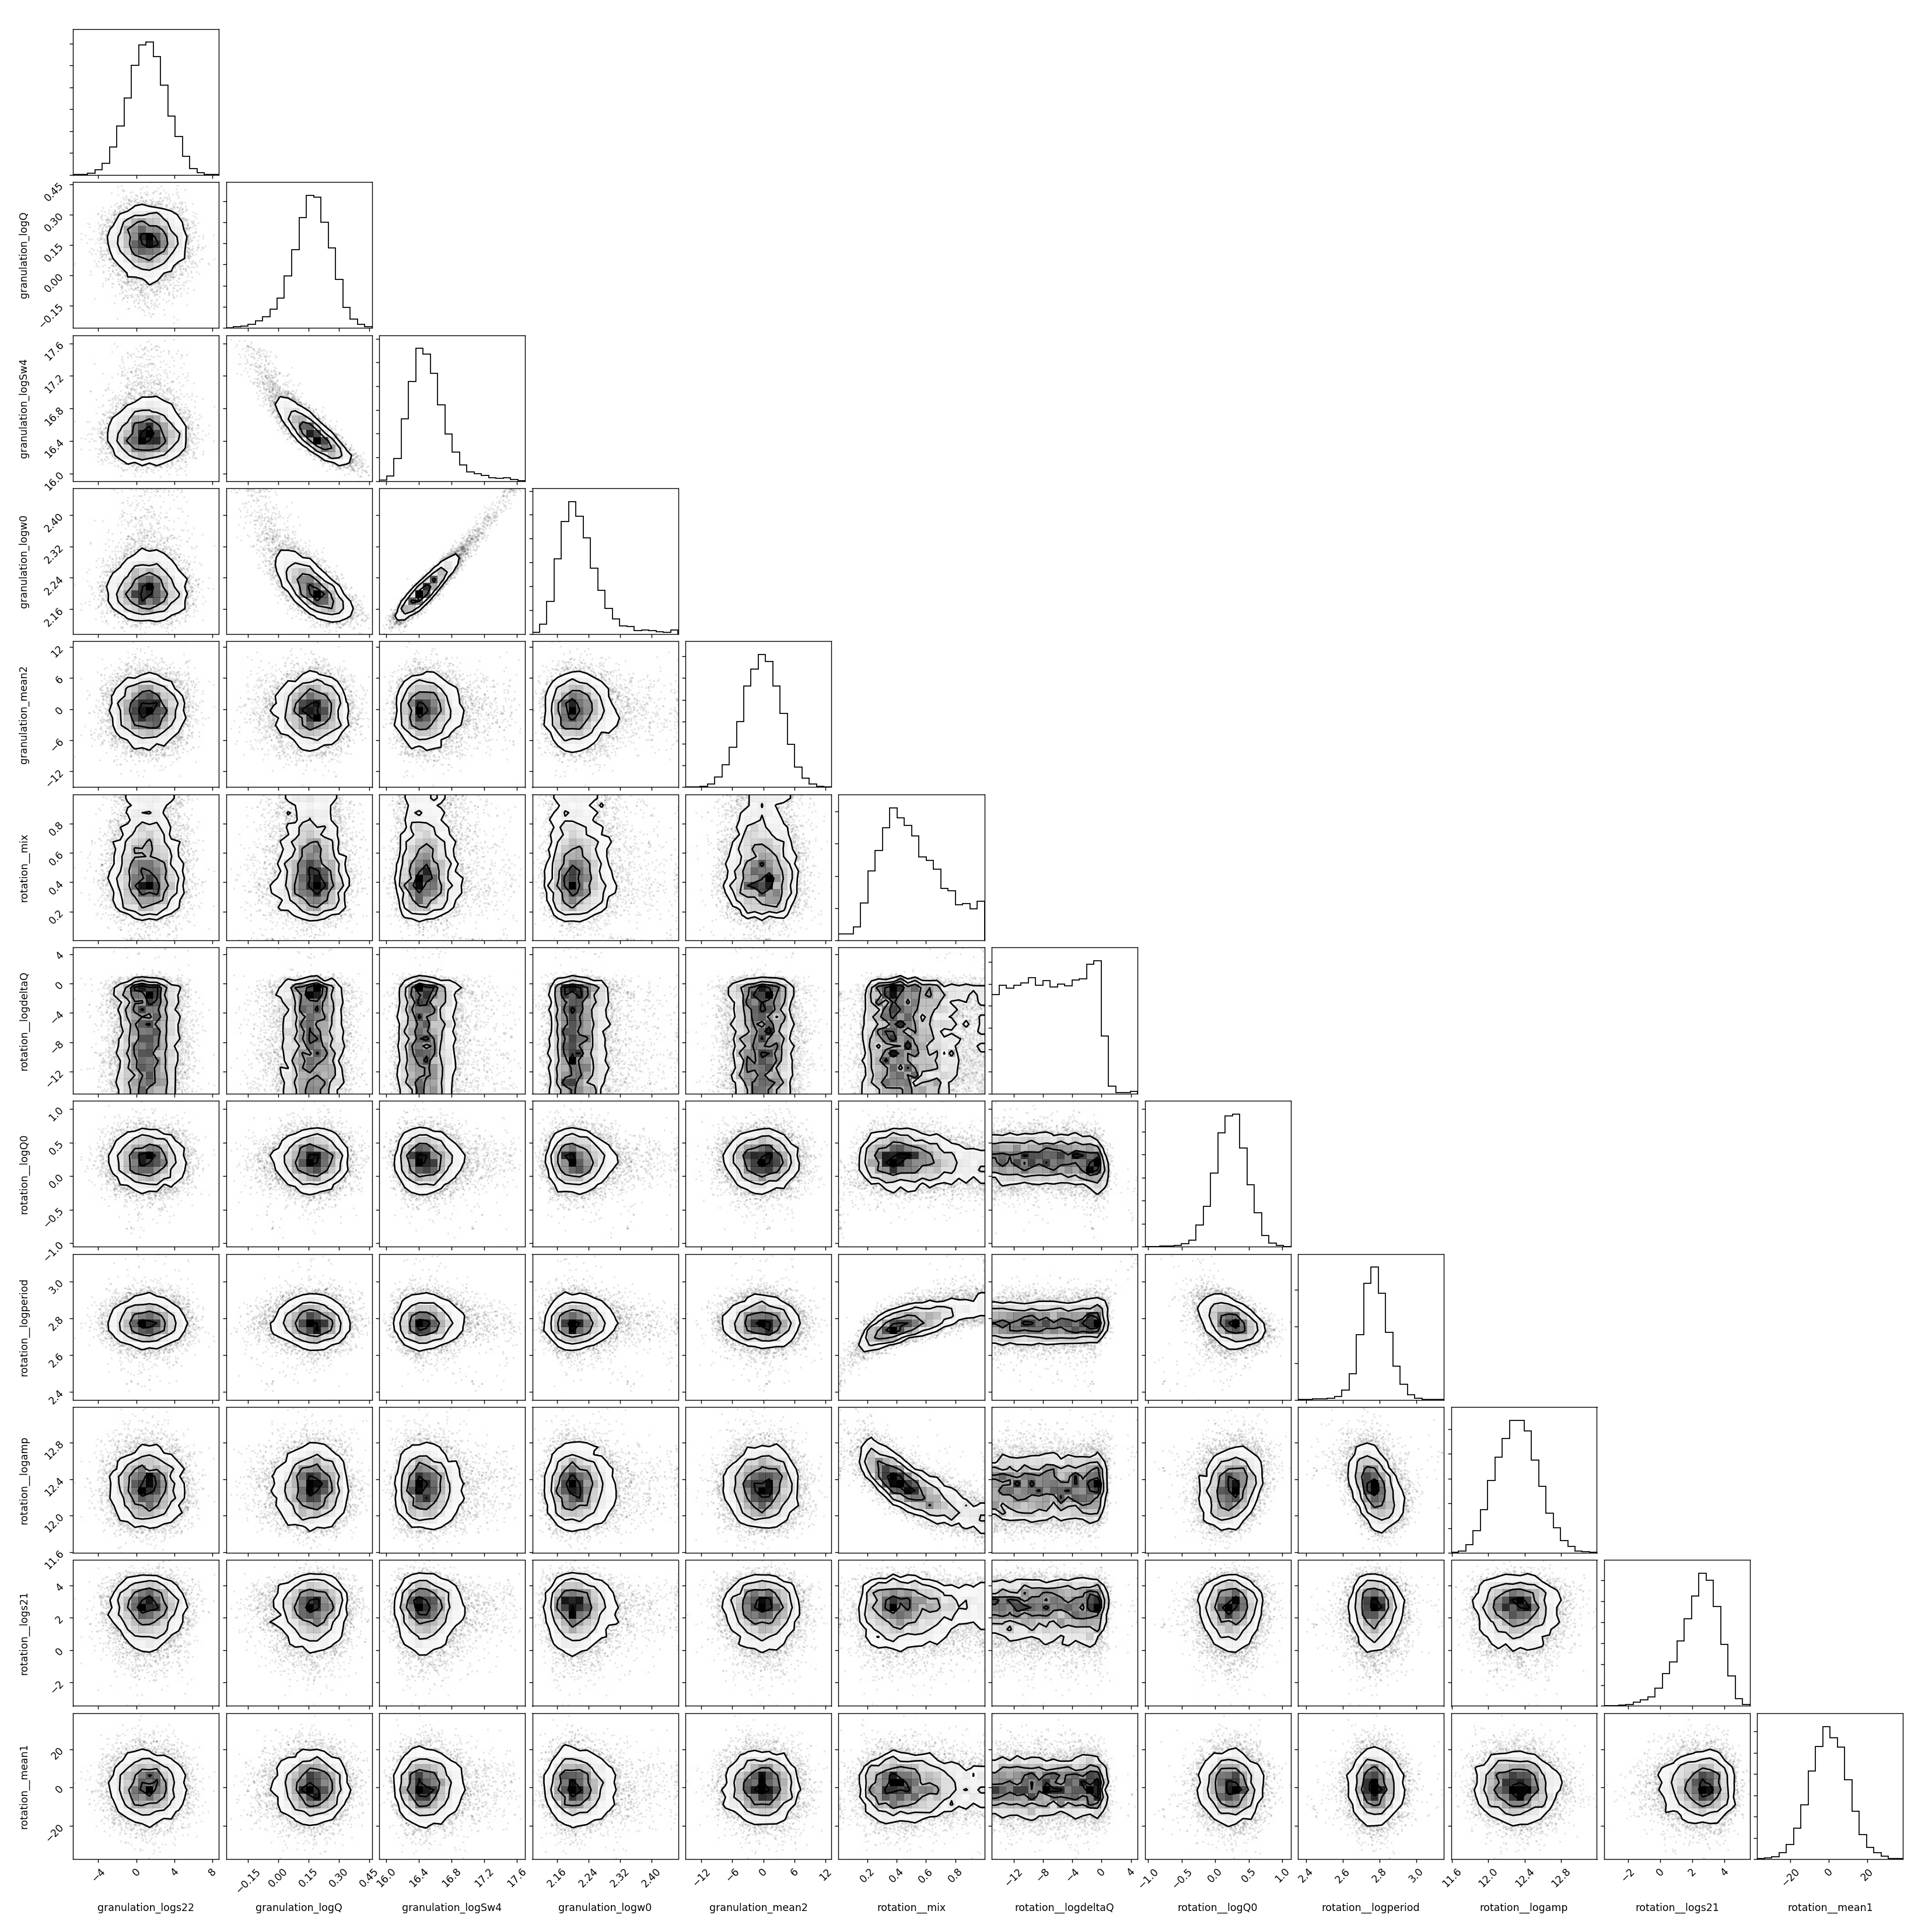

In [7]:
#check the corner plot
figure = vgp.corner()

<IPython.core.display.Javascript object>


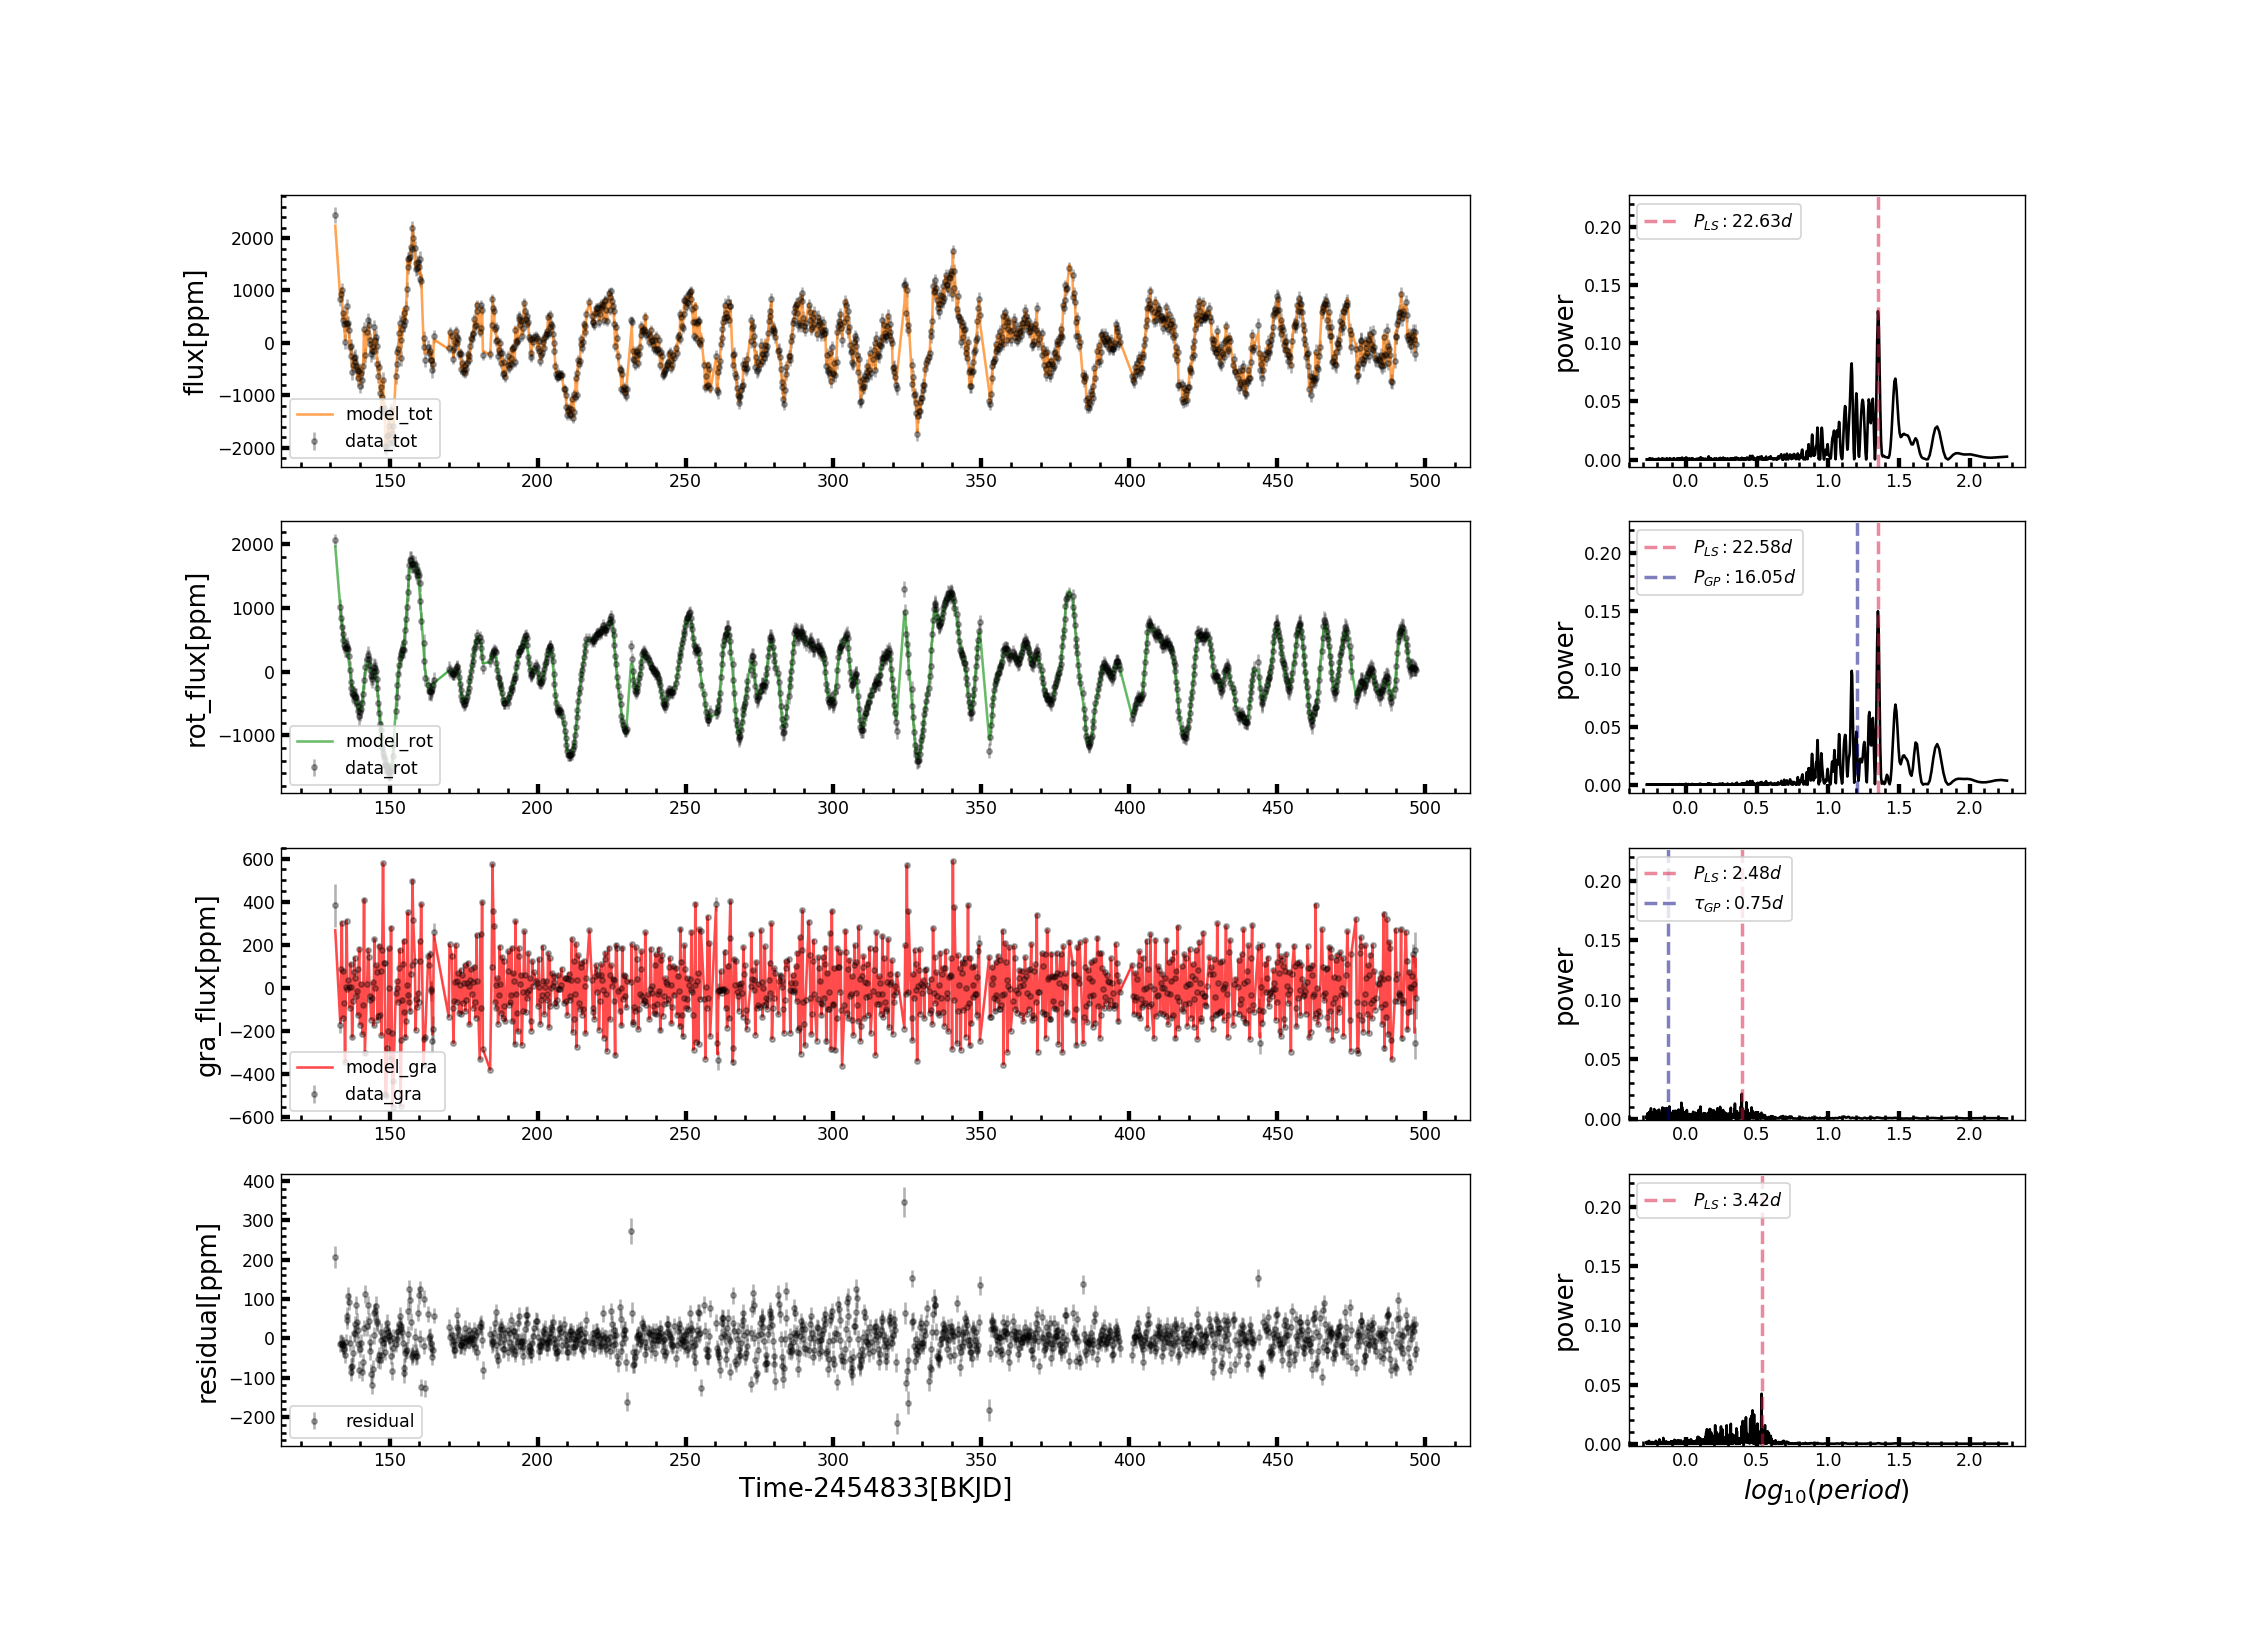

In [8]:
#check fitting plots
figure = vgp.GP_fitting_plots(summary)

<IPython.core.display.Javascript object>


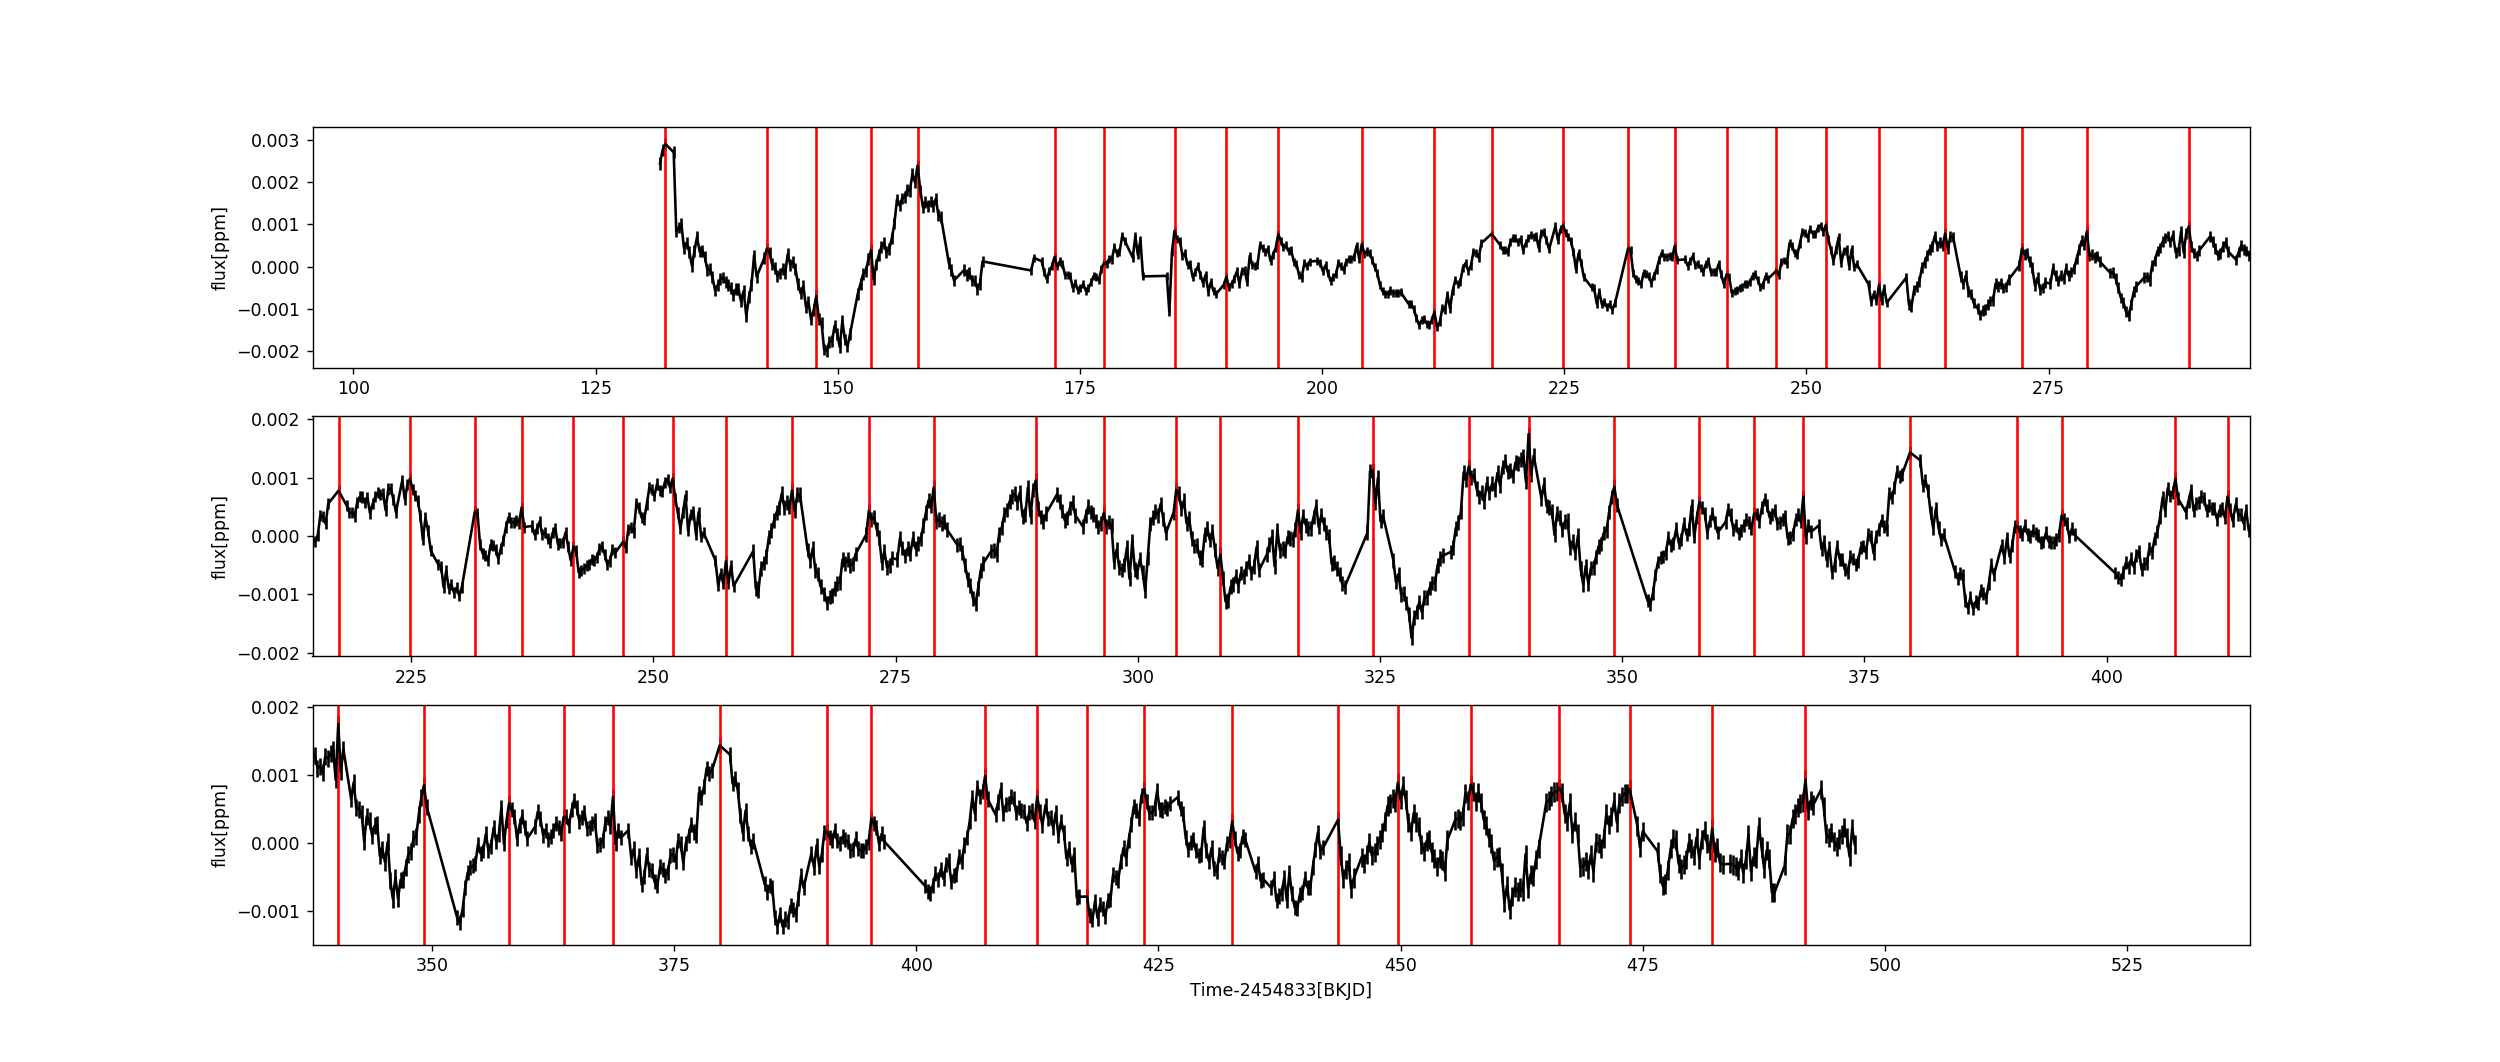

In [9]:
#This is a local view for the entire light curve
Pgp = np.exp(summary.loc['rotation__logperiod']['mean'])
fig1 = fig_local_view(sub, Pgp)

<IPython.core.display.Javascript object>


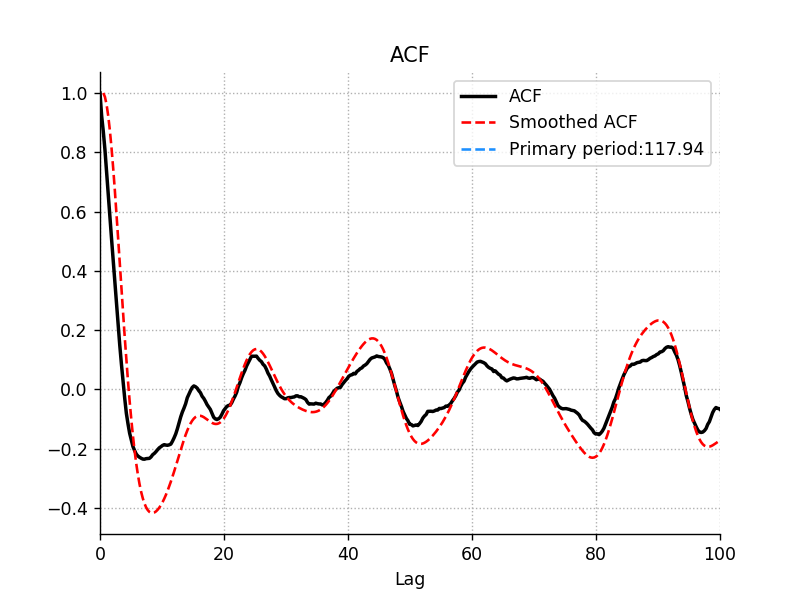

In [10]:
# plot the results given by acf
try:
    pacf, fig2 = fig_acf(sub)
except TypeError:
    pass

# 4. Save to hdf file

In [12]:
#You can save multiple subset in you hdf file here
hdf.append('epoch'+str(1), summary, 
               format='table', data_columns=True)
print("KOI-%s , epoch %s Done!" % (str(752), str(1)))

KOI-752 , epoch 1 Done!


/media/yangyangli/OS/yangyangli_private/anaconda3/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'hpd_3%'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/media/yangyangli/OS/yangyangli_private/anaconda3/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'hpd_97%'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/media/yangyangli/OS/yangyangli_private/anaconda3/lib/python3.7/site-packages/tables/attributeset.py:464: NaturalNameWarning: object name is not a valid Python identifier: 'hpd_3%_kind'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you wi